In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')


In [55]:
df = pd.read_csv('BikeSalesData - Copy.csv', 
                 parse_dates=['First_Seen','Last_Seen','Last Modified Date'], 
                 infer_datetime_format=True, 
                 na_values='-')
df.head()

,Unnamed: 0,1st Gear Ratio,2nd Gear Ratio,3rd Gear Ratio,4th Gear Ratio,5th Gear Ratio,6th Gear Ratio,ABS,ABS Selectable,Acceleration,...,Wheel Type,Wheelbase,Width,Width Including Mirrors,Winch,Windscreen,Windscreen Type,Unnamed: 201,Unnamed: 202,-
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Laced-spokes,"1,489 mm",827 mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Silver, 5-spoke; Die-cast aluminium alloy","1,490 mm",760 mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Cast Aluminium,NaN,720 mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Silver, Steel rims",820 mm,750 mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Drop known empty features
for col in list(df.columns):
    if 'Unnamed' in col:
        df.drop(col, axis=1, inplace=True)

df.drop('-', axis=1, inplace=True)


In [57]:
# Replace spaces with underscores in the feature list
df.columns = [col.replace('/', '_') for col in df.columns.str.lower()]
df.columns = [col.replace('-', '') for col in df.columns.str.lower()]
df.columns = [col.replace(' ', '_') for col in df.columns.str.lower()]
df.columns = [col.replace('__', '_') for col in df.columns.str.lower()]
df.columns = [col.replace('__', '_') for col in df.columns.str.lower()]


In [60]:
# Other feature processing
# - amalgamation, and removal.

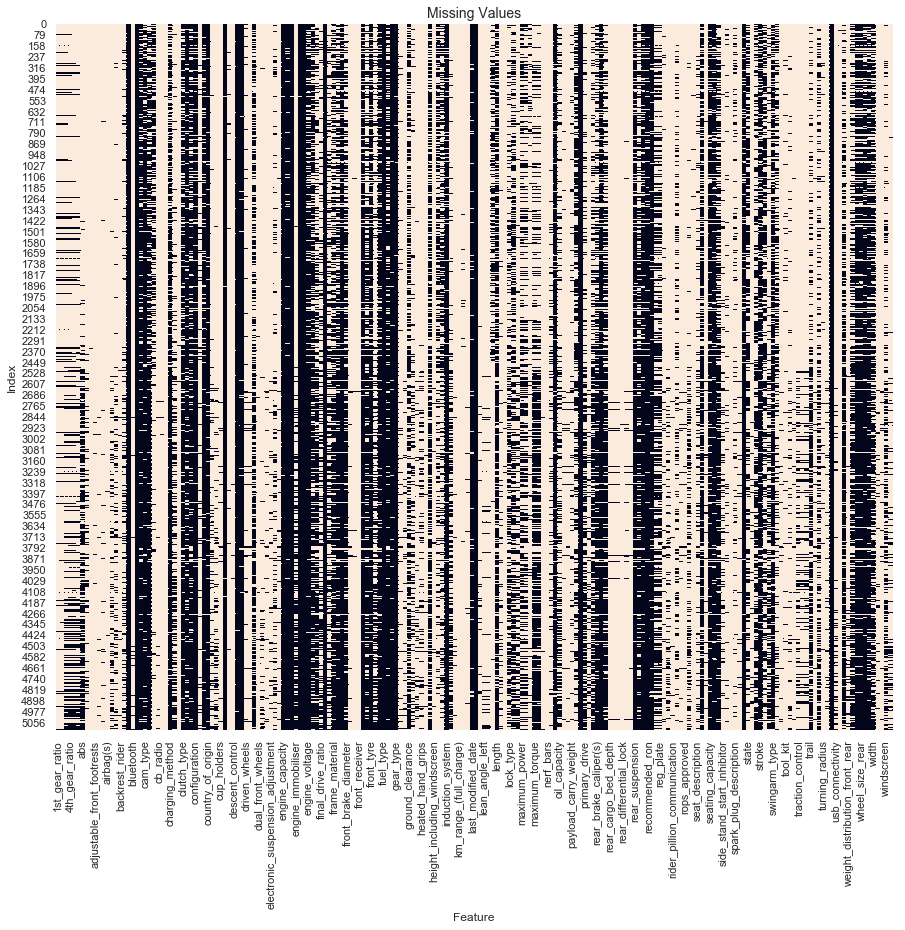

In [59]:
fig, ax = plt.subplots(figsize=(15,13))
sns.heatmap(df.isnull(), cbar=False, ax=ax)
plt.xlabel('Feature')
plt.ylabel('Index')
plt.title('Missing Values', fontsize=14)
plt.show()

In [58]:
list(df.columns)

['1st_gear_ratio',
 '2nd_gear_ratio',
 '3rd_gear_ratio',
 '4th_gear_ratio',
 '5th_gear_ratio',
 '6th_gear_ratio',
 'abs',
 'abs_selectable',
 'acceleration',
 'adjustable_front_footrests',
 'adjustable_rear_footrests',
 'adjustable_seat',
 'airbag(s)',
 'alarm',
 'backrest_pillion',
 'backrest_rider',
 'battery_description',
 'bike',
 'bluetooth',
 'body',
 'bore',
 'cam_type',
 'carburettor',
 'carburettor(s)',
 'cb_radio',
 'cd_player',
 'charge_time_(hrs)',
 'charging_method',
 'chassis_description',
 'clutch_diameter',
 'clutch_type',
 'colour',
 'compression_ratio',
 'configuration',
 'coolant_capacity',
 'cooling',
 'country_of_origin',
 'crash_bar',
 'cruise_control',
 'cup_holders',
 'cylinders',
 'decibel_rating',
 'descent_control',
 'description',
 'drive_type',
 'driven_wheels',
 'driver_restraint',
 'dry_weight',
 'dual_front_wheels',
 'economy_mode',
 'electronic_power_steering',
 'electronic_suspension_adjustment',
 'emission_standard',
 'engine_braking_system',
 'engine

True

In [51]:
list(df.columns)

['Unnamed: 0',
 '1st Gear Ratio',
 '2nd Gear Ratio',
 '3rd Gear Ratio',
 '4th Gear Ratio',
 '5th Gear Ratio',
 '6th Gear Ratio',
 'ABS',
 'ABS Selectable',
 'Acceleration',
 'Adjustable Front Footrests',
 'Adjustable Rear Footrests',
 'Adjustable Seat',
 'Airbag(s)',
 'Alarm',
 'Backrest - Pillion',
 'Backrest - Rider',
 'Battery Description',
 'Bike',
 'Bluetooth',
 'Body',
 'Bore',
 'Cam Type',
 'Carburettor',
 'Carburettor(s)',
 'CB Radio',
 'CD Player',
 'Charge Time (hrs)',
 'Charging Method',
 'Chassis Description',
 'Clutch Diameter',
 'Clutch Type',
 'Colour',
 'Compression Ratio',
 'Configuration',
 'Coolant Capacity',
 'Cooling',
 'Country of Origin',
 'Crash Bar',
 'Cruise Control',
 'Cup Holders',
 'Cylinders',
 'Decibel Rating',
 'Descent Control',
 'Description',
 'Drive Type',
 'Driven Wheels',
 'Driver Restraint',
 'Dry Weight',
 'Dual Front Wheels',
 'Economy Mode',
 'Electronic Power Steering',
 'Electronic Suspension Adjustment',
 'Emission Standard',
 'Engine Brakin